In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../')
print(f"New working dir {os.getcwd()}")

Old working dir /Users/vladimir.kondratyev/conditional_quantile_function/poc
New working dir /Users/vladimir.kondratyev/conditional_quantile_function


In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
from scipy.stats import norm, multivariate_normal

In [5]:
def _make_xy_dataloader(X: np.ndarray, Y: np.ndarray, batch_size: int, dtype=torch.float64) -> DataLoader:
    dataset = TensorDataset(torch.tensor(X, dtype=dtype), torch.tensor(Y, dtype=dtype))
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader


In [ ]:
from infrastructure.classes import TrainParameters
from pushforward_operators import NeuralQuantileRegression, AmortizedNeuralQuantileRegression


class OurCVQRegressor:

    def __init__(
        self,
        feature_dimension: int,
        response_dimension: int,
        hidden_dimension: int,
        number_of_hidden_layers: int,
        batch_size: int,
        n_epochs: int,
        learning_rate: float = 0.01,
        dtype=torch.float64,
    ):
        self.feature_dimension: int = feature_dimension
        self.response_dimension: int = response_dimension
        self.hidden_dimension: int = hidden_dimension
        self.number_of_hidden_layers: int = number_of_hidden_layers
        self.batch_size: int = batch_size
        self.n_epochs: int = n_epochs
        self.learning_rate: float = learning_rate
        self.dtype = dtype
        self.model = NeuralQuantileRegression(
            feature_dimension=self.feature_dimension,
            response_dimension=self.response_dimension,
            hidden_dimension=self.hidden_dimension,
            number_of_hidden_layers=self.number_of_hidden_layers,
            potential_to_estimate_with_neural_network="y",
        ).to(self.dtype)

    def fit(self, X: np.ndarray, Y:np.ndarray):
        dataloader = _make_xy_dataloader(X, Y, batch_size=self.batch_size, dtype=self.dtype)
        train_parameters = TrainParameters(number_of_epochs_to_train=self.n_epochs, 
                                           optimizer_parameters=dict(
                                                lr=self.learning_rate,
                                                betas=(0.5, 0.5),
                                                weight_decay=1e-4,
                                            ),
                                            warmup_iterations=10,
                                           scheduler_parameters={"eta_min": 0.},
                                           verbose=True)
        self.model.fit(dataloader, train_parameters=train_parameters,)

    def predict_mean(self, X):
        n = X.shape[0]
        U = torch.zeros((n, self.response_dimension), dtype=self.dtype)
        X_tensor = torch.tensor(X, dtype=self.dtype)
        #dataset = TensorDataset(X_tensor, U)
        #dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        Y = self.model.push_u_given_x(x=X_tensor, u=U)
        return Y.numpy(force=True)
    
    def predict_quantile(self, X, Y):
        return self.model.push_y_given_x(y=torch.tensor(Y), 
                                         x=torch.tensor(X)).numpy(force=True)


In [7]:
from conformal.real_datasets.reproducible_split import get_dataset_split, DatasetSplit
from utils.network import get_total_number_of_parameters

In [8]:
seed = 0
dataset_name = "blog"
# dataset_name = "rf1"

ds = get_dataset_split(name=dataset_name, seed=seed)

Extracting 'blogData_train.csv' from '/Users/vladimir.kondratyev/conditional_quantile_function/data/raw/e559de999e47bf7ab2d744e52ba1fbe5-blogfeedback.zip' to '/Users/vladimir.kondratyev/conditional_quantile_function/data/raw/e559de999e47bf7ab2d744e52ba1fbe5-blogfeedback.zip.unzip'


Removed columns: 0 + 10 + 0 = 10 over 279
Removed rows: 0


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from metrics.wsc import wsc_unbiased

## Algorithms according to section 5

In [10]:
alpha = 0.1

In [11]:
from IPython.display import display, Markdown

In [12]:
ds.X_train.shape, ds.Y_train.shape

((48397, 100), (48397, 2))

### Part 1: Train base model $\tilde{Q}_{Y|X}^{-1}(X, Y)$ on train set

In [17]:
reg = OurCVQRegressor(
    feature_dimension=100,
    response_dimension=2,
    hidden_dimension=16,
    number_of_hidden_layers=4,
    batch_size=512,
    n_epochs=100,
    learning_rate=1e-2
)

print(f"Number of parameters: {get_total_number_of_parameters(reg.model)}, number of training samples: {ds.n_train}.")

Number of parameters: 8504, number of training samples: 48397.


In [18]:
ds.X_train.shape, ds.Y_train.shape

((48397, 100), (48397, 2))

In [20]:
model_savepath = f"neural_quantile_regression_log.pth"
if not os.path.isfile(model_savepath):
    reg.fit(ds.X_train, ds.Y_train)
    reg.model.save(model_savepath)
    reg.model.eval()
else:
    reg.model.load(model_savepath)
    reg.model.eval()

Epoch: 32, Objective: 0.490, LR: 0.007754:  31%|███       | 31/100 [24:41<54:58, 47.80s/it]  


KeyboardInterrupt: 

In [15]:
model_savepath

'neural_qr_v0_bio.pth'

In [16]:

reg.model.save(model_savepath)

In [17]:
reg.model.to(torch.tensor(ds.X_cal))
quantiles_cal = reg.predict_quantile(ds.X_cal, ds.Y_cal)
quantiles_test = reg.predict_quantile(ds.X_test, ds.Y_test)

Diagnstic plots for quantiles

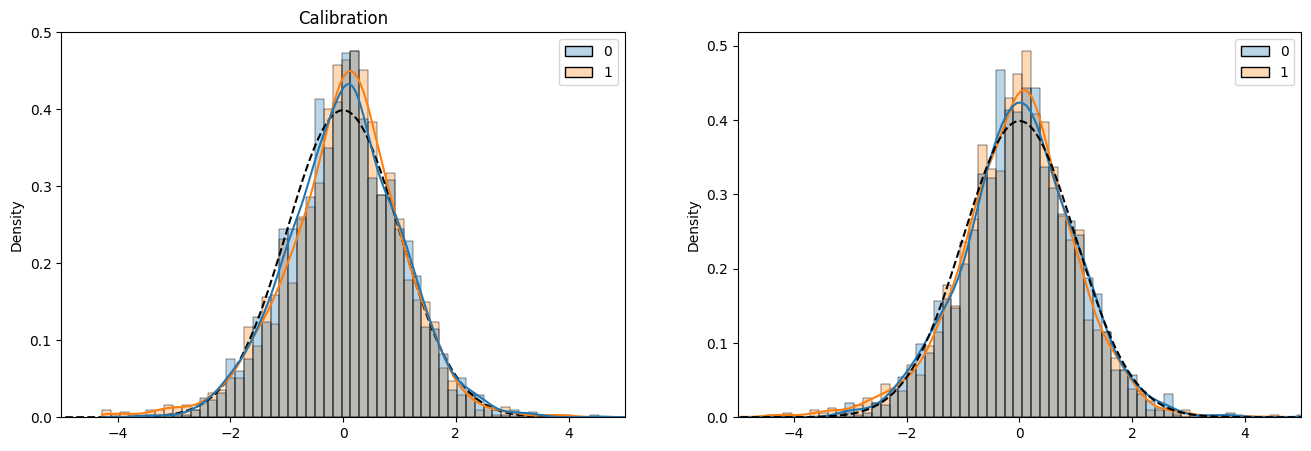

In [18]:
from scipy.stats import expon

t_min = min(quantiles_cal.min(), quantiles_test.min())
t_max = max(quantiles_cal.max(), quantiles_test.max())
t = np.linspace(t_min, t_max, 500)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
p0 = ax[0].plot(t, norm.pdf(t), 'k--', label="N(0, 1)")
hp0 = sns.histplot(quantiles_cal, alpha=0.3, stat="density", common_norm=False, kde=True, ax=ax[0])
ax[0].set_title("Calibration")
ax[0].set_xlim(-5, 5)
hp1 = sns.histplot(quantiles_test, alpha=0.3, stat="density", common_norm=False, kde=True, ax=ax[1])
p1 = ax[1].plot(t, norm.pdf(t), 'k--', label="N(0, 1)")
# ax[1].set_title("Test")
ax[1].set_xlim(-5, 5)

plt.show()

In [19]:
from scipy import stats

def draw_qq_scores(scores, ax):
    n, d = scores.shape
    for j in range(d):
        stats.probplot(
            scores[:, j],
            dist="norm",
            fit=False,
            plot=ax,
        )
        ax.get_lines()[j].set_markerfacecolor(f'C{j}')
        ax.get_lines()[j].set_markeredgecolor(f'C{j}')
    ax.plot([-3, 3], [-3, 3], ls='--', c='k')


Text(0.5, 1.0, 'Test')

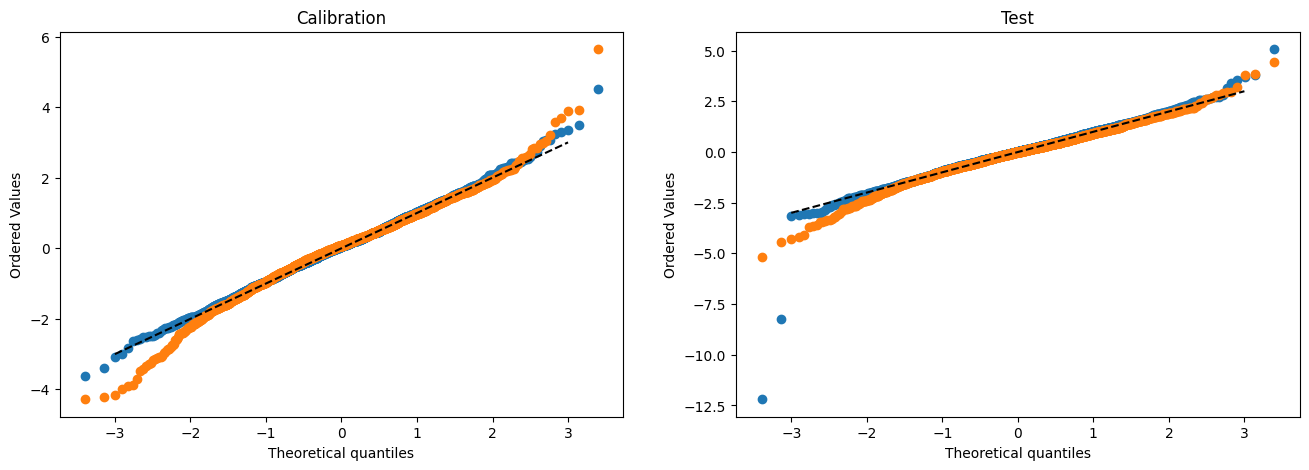

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
draw_qq_scores(quantiles_cal, ax[0])
ax[0].set_title("Calibration")
draw_qq_scores(quantiles_test, ax[1])
ax[1].set_title("Test")

### Part 2: Implement Method 5.1a (only marginal calibration)

Scores $S_i = || \tilde{Q}_{Y|X}^{-1}(X_i, Y_i) ||$, for $(X_i, Y_i) \in \mathcal{D}_{\mathrm{cal}}$

In [21]:
scores_cal_51a = np.linalg.norm(quantiles_cal, axis=1)
scores_test_51a = np.linalg.norm(quantiles_test, axis=1)

threshold_51a = np.quantile(scores_cal_51a, q=(ds.n_cal + 1) * (1 - alpha) / ds.n_cal)

In [22]:
import tqdm
is_covered_51a = scores_test_51a <= threshold_51a
list_of_wsc_51 = []

trange = tqdm.trange(10)

for i in trange:
    cov_51a = is_covered_51a.mean()
    wsc_51a = wsc_unbiased(ds.X_test, is_covered_51a, delta=0.1, M=10000, random_state=i, n_cpus=8)
    list_of_wsc_51.append(wsc_51a)
    if i >= 2:
        trange.set_postfix({
            "Worst-slab":torch.tensor(list_of_wsc_51).mean().item(),
            "+-":torch.tensor(list_of_wsc_51).std().item()
        })

100%|██████████| 10/10 [00:22<00:00,  2.27s/it, Worst-slab=0.906, +-=0.0275]


### Part 3: Implement Method 5.1b (re-calibration)

Split calibration set in half and use static Monge-Cantorovich reranking.

In [23]:
# From official implementation of OT-CP paper
from conformal.otcp.functions_refactor import MultivQuantileTresholdRefactor, RankFuncRefactor


def _get_coverage_otcp(scores, mu, psi, q_hat, verbose=False):
    # Computing coverage on test set
    ConditionalRank = RankFuncRefactor(scores, mu, psi)
    rank_1d = np.linalg.norm(ConditionalRank, axis=1)
    if verbose:
        print(f"{len(np.unique(rank_1d))=}")
    is_covered_otcp = rank_1d <= q_hat
    return is_covered_otcp


def otcp_predict_coverage(scores_cal1, scores_cal2, scores_test, q=0.9, verbose=False):
    Quantile_Treshold, mu, psi, psi_star, data_calib = \
        MultivQuantileTresholdRefactor(scores_cal1, scores_cal2, alpha=q)

    # Computing coverage on test set
    is_covered_otcp = _get_coverage_otcp(scores_test, mu, psi, Quantile_Treshold, verbose=verbose)
    return is_covered_otcp, mu, psi, Quantile_Treshold

In [24]:
import tqdm
is_covered_51a = scores_test_51a <= threshold_51a
list_of_wsc_51b = []

trange = tqdm.trange(10)

for i in trange:
    n1 = ds.n_cal // 2

    is_covered_51b, mu, psi, threshold_51b = otcp_predict_coverage(
        scores_cal1=quantiles_cal[:n1],
        scores_cal2=quantiles_cal[n1:],
        scores_test=quantiles_test,
        q=1 - alpha
    )

    cov_51b = is_covered_51b.mean()
    wsc_51b = wsc_unbiased(ds.X_test, is_covered_51b, delta=0.1, M=10000, random_state=i, n_cpus=8, verbose=False)
    list_of_wsc_51b.append(wsc_51b)

    if i >= 2:
        trange.set_postfix({
            "Worst-slab":torch.tensor(list_of_wsc_51b).mean().item(),
            "+-":torch.tensor(list_of_wsc_51b).std().item()
        })
    
# for rs in range(10):
#     n1 = ds.n_cal // 2

#     is_covered_51b, mu, psi, threshold_51b = otcp_predict_coverage(
#         scores_cal1=quantiles_cal[:n1],
#         scores_cal2=quantiles_cal[n1:],
#         scores_test=quantiles_test,
#         q=1 - alpha
#     )

#     cov_51b = is_covered_51b.mean()
#     wsc_51b = wsc_unbiased(ds.X_test, is_covered_51b, delta=0.1, M=10000, random_state=rs, n_cpus=8, verbose=False)
#     display(
#         Markdown(
#             r"#### $\mathcal{C}_{\rho}^{\mathrm{rpb}}$ Marginal coverage: " +
#             f"**{cov_51b:.2f}**, " +
#             f"worst-slab conditional coverage: **{wsc_51b:.2f}**"
#         )
#     )

100%|██████████| 10/10 [00:23<00:00,  2.38s/it, Worst-slab=0.904, +-=0.021]


To get good conditional coverage, reranking map has to be fitted on a large sample.

### Part 4: implement Method 5.2 HPD-based scores

In [25]:
from torch.func import hessian

In [26]:
compute_batch_hessian = torch.vmap(func=hessian(reg.model.potential_network, argnums=1), 
                                   in_dims=0, chunk_size=1024)

hessians_cal = compute_batch_hessian(torch.tensor(ds.X_cal), torch.tensor(ds.Y_cal)).squeeze()
hessians_test = compute_batch_hessian(torch.tensor(ds.X_test), torch.tensor(ds.Y_test)).squeeze()

In [27]:
logdet_hessians_cal = torch.logdet(hessians_cal).numpy(force=True)
logdet_hessians_test = torch.logdet(hessians_test).numpy(force=True)

In [28]:
log_f_u_cal = multivariate_normal.logpdf(quantiles_cal, mean=np.zeros(2))
log_f_u_test = multivariate_normal.logpdf(quantiles_test, mean=np.zeros(2))

In [29]:
scores_cal_52 = log_f_u_cal + logdet_hessians_cal
scores_test_52 = log_f_u_test + logdet_hessians_test

# scores_cal_52 = reg.model.flow.logp(torch.tensor(ds.Y_cal), torch.tensor(ds.X_cal)).numpy(force=True)
# scores_test_52 = reg.model.flow.logp(torch.tensor(ds.Y_test), torch.tensor(ds.X_test)).numpy(force=True)

(array([1.48e+03, 3.06e+02, 1.31e+02, 4.30e+01, 1.90e+01, 1.30e+01,
        4.00e+00, 2.00e+00, 1.00e+00, 1.00e+00]),
 array([4.69171315e-12, 9.07056091e+00, 1.81411218e+01, 2.72116827e+01,
        3.62822436e+01, 4.53528046e+01, 5.44233655e+01, 6.34939264e+01,
        7.25644873e+01, 8.16350482e+01, 9.07056091e+01]),
 <BarContainer object of 10 artists>)

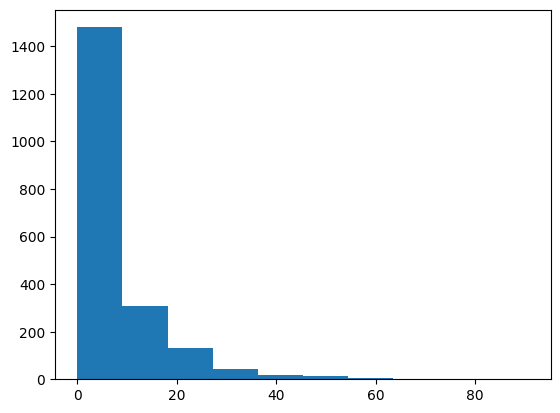

In [30]:
plt.hist(torch.exp(torch.tensor(scores_cal_52)))

In [31]:
for rs in range(10):
    threshold_52 = np.quantile(scores_cal_52, q=(ds.n_cal + 1) * (alpha) / ds.n_cal)

    is_covered_52 = scores_test_52 >= threshold_52

    cov_52 = is_covered_52.mean()
    wsc_52 = wsc_unbiased(ds.X_test, is_covered_52, delta=0.1, M=10000, random_state=rs, n_cpus=8)

    display(
        Markdown(
            r"#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: " +
            f"**{cov_52:.2f}**, " +
            f"worst-slab conditional coverage: **{wsc_52:.2f}**"
        )
    )

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.96**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.85**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.94**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.80**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.89**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.89**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.90**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.83**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.82**

#### $\mathcal{C}_{\rho}^{\mathrm{HPD}}$ Marginal coverage: **0.90**, worst-slab conditional coverage: **0.91**

## Part 5: estimate areas

In [32]:
from tqdm.auto import tqdm


ymin = ds.Y_train.min(axis=0)
ymax = ds.Y_train.max(axis=0)

scale = np.prod(ymax - ymin)
n_samples = 10000


In [33]:
ymin, ymax, scale

(array([-1.9536383, -3.2120101], dtype=float32),
 array([49.861794 ,  3.4745758], dtype=float32),
 np.float32(346.46835))

In [34]:
X_test_sampled = np.repeat(ds.X_test, repeats=n_samples, axis=0)
Y_test_sampled = ymin + np.random.default_rng(31337).random((n_samples * ds.n_test, 2)
                                         ) * (ymax - ymin)
X_test_sampled.shape, Y_test_sampled.shape

((20000000, 8), (20000000, 2))

In [35]:
ds.Y_test[0], Y_test_sampled[0]

(array([-0.7403489,  1.4478455], dtype=float32),
 array([16.5920897,  2.4752225]))

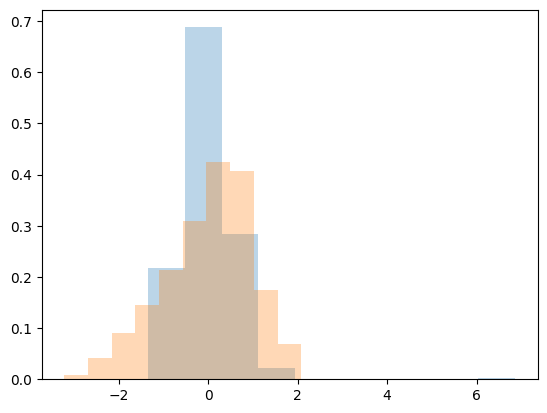

In [36]:
plt.figure()
plt.hist(ds.Y_test[:, 0], label='Test', alpha=0.3, density=True)
plt.hist(ds.Y_test[:, 1], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 2], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 3], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 3], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 4], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 5], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 6], label='Test', alpha=0.3, density=True)
# plt.hist(ds.Y_test[:, 7], label='Test', alpha=0.3, density=True)
# plt.hist(Y_test_sampled[:, 1], label='Samples for areas', alpha=0.3, density=True)
plt.show()


In [55]:
is_covered_sampled_51b = np.zeros(ds.n_test * n_samples)
quantiles_test_sampled = np.zeros((ds.n_test * n_samples, 2))
print(is_covered_sampled_51b.shape)
for i in tqdm(range(ds.n_test)):
    start = i * n_samples
    stop = (i + 1) * n_samples
    quantiles_test_sampled[start:stop] = \
        reg.predict_quantile(X_test_sampled[start:stop], Y_test_sampled[start:stop])
    is_covered_sampled_51b[start:stop] = \
        _get_coverage_otcp(quantiles_test_sampled[start:stop], mu, psi, threshold_51b, verbose=False)


is_covered_sampled_51a = np.linalg.norm(quantiles_test_sampled, axis=1) <= threshold_51a

is_covered_sampled_51a.shape, is_covered_sampled_51b.shape

(20000000,)


  0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: mixed dtype (CPU): all inputs must share same datatype.

In [70]:
np.linalg.norm(quantiles_test_sampled, axis=1)**2

array([1349.92793945, 2503.44224426,  414.15608348, ...,  273.45274222,
        193.61996584,  331.65930173], shape=(20000000,))

In [71]:
from scipy import stats


def draw_qq_scores(scores, ax):
    n, d = scores.shape
    for j in range(d):
        stats.probplot(
            scores[:, j],
            dist="norm",
            fit=False,
            plot=ax,
        )
        ax.get_lines()[j].set_markerfacecolor(f'C{j}')
        ax.get_lines()[j].set_markeredgecolor(f'C{j}')
    ax.plot([-3, 3], [-3, 3], ls='--', c='k')


In [72]:
import gc

reg.model.cpu()
_compute_batch_hessian = torch.vmap(func=hessian(reg.model.potential_network, argnums=1), 
                                   in_dims=0, chunk_size=8192)

log_det_hessians_test_samples = np.zeros(ds.n_test * n_samples)
for i in tqdm(range(ds.n_test // 8)):
    start = i * n_samples * 8
    stop = (i + 1) * n_samples * 8
    if i % 200 == 0:
        print(i, start, stop)

    _hessians = _compute_batch_hessian(
        torch.tensor(X_test_sampled[start:stop]),
        torch.tensor(Y_test_sampled[start:stop])
    )[:, 0].detach()

    log_det_hessians_test_samples[start:stop] = \
        torch.logdet(_hessians).squeeze().detach().numpy(force=True)

    if i > 0 and i % 100 == 0:
        gc.collect()
_ = reg.model.cpu()

  0%|          | 0/250 [00:00<?, ?it/s]

0 0 80000
200 16000000 16080000


In [73]:
print(f"{log_det_hessians_test_samples.shape=}")
log_f_u_test_samples = multivariate_normal.logpdf(quantiles_test_sampled, mean=np.zeros(4))
log_dets_test_sampled = log_det_hessians_test_samples
scores_test_sampled_52 = log_f_u_test_samples + log_dets_test_sampled
is_covered_sampled_52 = scores_test_sampled_52 >= threshold_52

log_det_hessians_test_samples.shape=(20000000,)


In [74]:
quantiles_test_sampled.shape, 

((20000000, 4),)

In [75]:
X = ds.X_test[0:1]

In [76]:
Y_max_tensor, Y_min_tensor = torch.tensor(ymax), torch.tensor(ymin)
X_tensor = torch.tensor(X).repeat((10_000, 1))
Y_tensor = Y_min_tensor + torch.rand((10_000, 4)) * (Y_max_tensor - Y_min_tensor)
U_tensor = torch.randn(10_000, 4).to(Y_tensor)

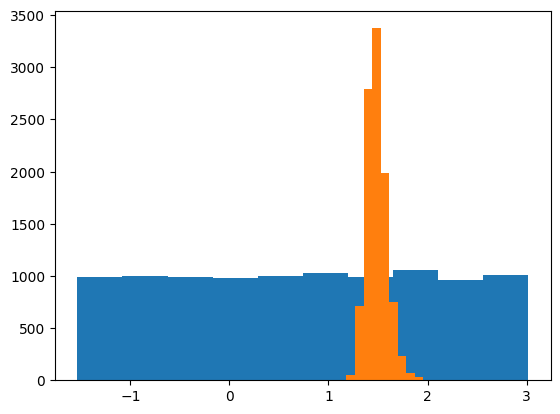

In [77]:
plt.hist(Y_tensor[:, 0])
plt.hist(reg.model.push_u_given_x(U_tensor, X_tensor)[:, 0])
plt.show()

(array([1.000e+00, 9.000e+00, 1.390e+02, 6.810e+02, 2.065e+03, 3.073e+03,
        2.543e+03, 1.152e+03, 3.030e+02, 3.400e+01]),
 array([-4.50258255, -3.71246505, -2.92234755, -2.13223004, -1.34211254,
        -0.55199504,  0.23812246,  1.0282402 ,  1.81835747,  2.60847473,
         3.39859247]),
 <BarContainer object of 10 artists>)

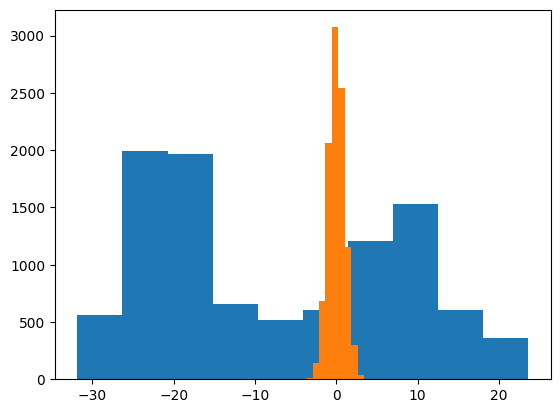

In [78]:
plt.hist(reg.model.push_y_given_x(Y_tensor, X_tensor)[:, 0])
plt.hist(torch.randn(10_000))

In [79]:
log_det_hessians_test_samples, log_f_u_test_samples

(array([4.91650256, 4.96865414, 6.84131262, ..., 6.71111284, 6.10256249,
        5.03675056], shape=(20000000,)),
 array([ -678.63972386, -1255.39687626,  -210.75379587, ...,
         -140.40212524,  -100.48573705,  -169.505405  ], shape=(20000000,)))

In [80]:
is_covered_sampled_51a.shape

(20000000,)

In [81]:
areas_51a, areas_51b, areas_52 = map(lambda t: t.reshape(ds.n_test, n_samples).mean(axis=-1) * scale, 
                                     (is_covered_sampled_51a, is_covered_sampled_51b, is_covered_sampled_52))

In [82]:
areas_51a[0]

np.float64(0.0)

(array([1892.,   47.,   28.,   10.,    8.,    3.,    3.,    2.,    4.,
           3.]),
 array([0.        , 0.48967021, 0.97934041, 1.46901062, 1.95868083,
        2.44835104, 2.93802124, 3.42769145, 3.91736166, 4.40703186,
        4.89670207]),
 <BarContainer object of 10 artists>)

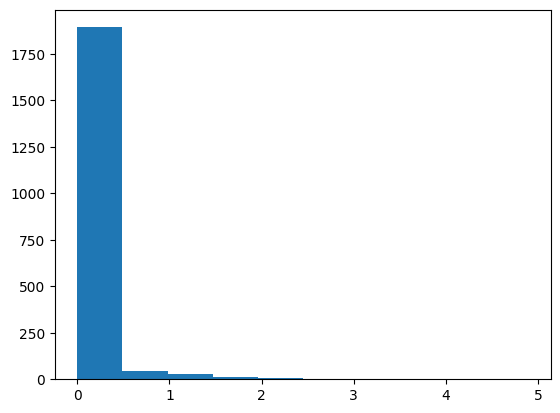

In [83]:
plt.hist(areas_51a)

In [84]:
areas_52.mean()

np.float64(0.014690106215382847)

In [85]:
display(
    Markdown(
        r"#### Areas \n ${\mathrm{PB}}$:   " +
        f"**{areas_51a.mean():.2f}**,  " + 
        r"${\mathrm{RPB}}$:   " +
        f"**{areas_51b.mean():.2f}**,  " + 
        r"${\mathrm{HPD}}$:   " +
        f"**{areas_52.mean():.2f}**,  "
    )
)
3

#### Areas \n ${\mathrm{PB}}$:   **0.12**,  ${\mathrm{RPB}}$:   **0.14**,  ${\mathrm{HPD}}$:   **0.01**,  

3

In [86]:
(threshold_51a, threshold_51b, threshold_52)

(np.float64(2.290341356761194),
 np.float64(0.6916916916916916),
 np.float64(2.3228225648323586))

In [87]:
is_covered_sampled_52.mean(), is_covered_sampled_52.sum()

(np.float64(1.8e-05), np.int64(360))

In [88]:
is_covered_sampled_51a.mean(), is_covered_sampled_51a.sum()

(np.float64(0.0001422), np.int64(2844))

In [89]:
is_covered_sampled_51b.mean(), is_covered_sampled_51b.sum()

(np.float64(0.0001735), np.float64(3470.0))

In [90]:
0.4 ** 8

0.0006553600000000003

In [91]:
log_f_u_test_samples[:10], log_dets_test_sampled[:10]

(array([ -678.63972386, -1255.39687626,  -210.75379587,  -637.18089152,
        -1326.71034144,  -797.30617238,  -488.78149603,  -385.2672454 ,
         -447.6891932 ,  -446.90636179]),
 array([ 4.91650256,  4.96865414,  6.84131262, -1.53886575,  3.20294564,
         2.92461019,  3.60325096,  5.34653531,  7.91124724,  3.56430129]))

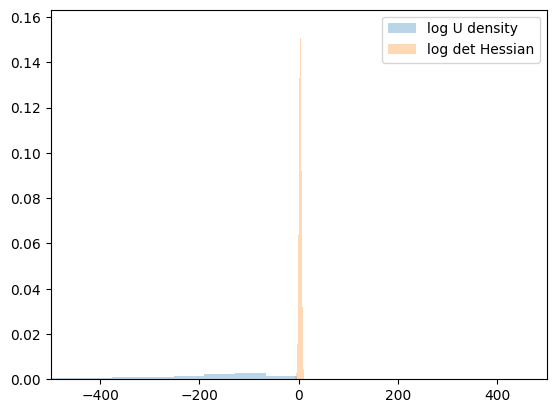

In [92]:
plt.figure()
plt.hist(log_f_u_test_samples, bins=500, density=True, alpha=0.3, label="log U density")
plt.hist(log_dets_test_sampled, bins=500, density=True, alpha=0.3, label="log det Hessian")
plt.xlim(-500, 500)
plt.legend()
plt.show()

In [93]:
scale

np.float64(816.1170119657136)

In [94]:
areas_51b

array([0.       , 0.0816117, 0.       , ..., 0.1632234, 0.       ,
       0.       ], shape=(2000,))

In [95]:
is_covered_sampled_51a.mean(), is_covered_sampled_51b.mean(), is_covered_sampled_52.mean()

(np.float64(0.0001422), np.float64(0.0001735), np.float64(1.8e-05))